In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy
import scipy.special as special
import scipy.stats as stats
import scipy.integrate as integrate

import matplotlib.colors as colors

The error function is an entire function; it has no singularities (except that at infinity) and its Taylor expansion always converges.

The defining integral cannot be evaluated in closed form in terms of elementary functions, but by expanding the integrand $e^{−z^2}$ into its Maclaurin series and integrating term by term, one obtains the error function's Maclaurin series as:

$$ \operatorname {erf} (z)={\frac {2}{\sqrt {\pi }}}\sum _{n=0}^{\infty }{\frac {(-1)^{n}z^{2n+1}}{n!(2n+1)}}={\frac {2}{\sqrt {\pi }}}\left(z-{\frac {z^{3}}{3}}+{\frac {z^{5}}{10}}-{\frac {z^{7}}{42}}+{\frac {z^{9}}{216}}-\cdots \right) $$

which holds for every complex number z. 

### Tasks
The special.erf method is vectorized so that we can obtain multiple values for input sequences and grid

#### Write a vectorized function using the Taylor series algorithm. 

In [2]:
def erf_taylor(z, nterms=19):
    '''
    
    '''
    #Cast to numpy array
    z = np.array(z)
    
    terms = np.zeros((nterms,)+z.shape, dtype=np.complex128)
    terms[0] = z
    z2 = -z*z  # move math outside loop
    for n in range(1,nterms):
        terms[n] = terms[n-1] * z2 / n * (2*n-1)/(2*n+1)
    
    return np.sum(terms, axis=0) * 2.0 / np.sqrt(np.pi)

#### Compare results to special.erf and determine relative precision of the Taylor series algorithm for $|z| < 9$.

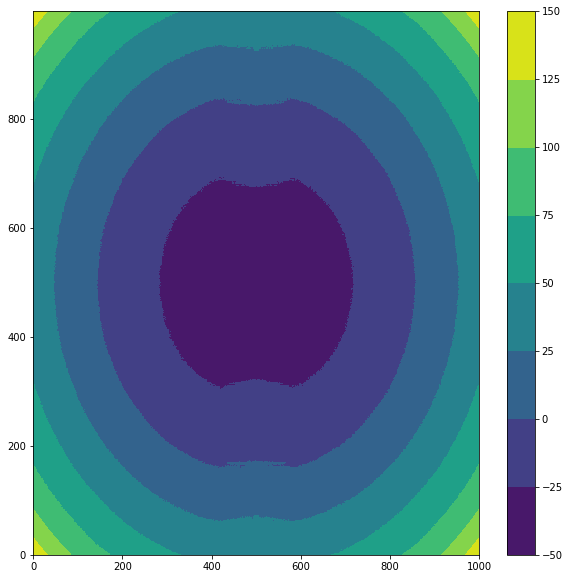

In [13]:
plt.figure(figsize = (10,10))

x,y = np.linspace(-9, +9, 1001),np.linspace(-9, +9, 999)
xx, yy = np.meshgrid(x, 1.0j*y)
gridxy = xx + yy
z1 = special.erf(gridxy)
z2 = erf_taylor(gridxy,nterms=236)
array = np.abs(z1-z2)
masked_array = array + (array<=1e-16)*1e-16
masked_array = np.log(masked_array)

plt.contourf(masked_array)#,norm=colors.LogNorm(),cmap=cmap)
plt.colorbar()
plt.show()

#### Write python code for some more complex algorithm that you find on the web ie.

Efficient Computation of the Complex Error Function
Walter Gautschi
SIAM Journal on Numerical Analysis
Vol. 7, No. 1 (Mar., 1970), pp. 187-198

Computation of the Complex Error Function
J. A. C. Weideman
SIAM Journal on Numerical Analysis
Vol. 31, No. 5 (Oct., 1994), pp. 1497-1518

More efficient computation of the complex error function.
G. P. M. Poppe and C. M. J. Wijers. 1990
ACM Trans. Math. Softw. 16, 1 (March 1990), 38-46. 
DOI: https://doi.org/10.1145/77626.77629

In [68]:
def w(z):
    #Works in first quadrant only
    x, y = np.real(z), np.imag(z)
    
    if y<4.29 and x<5.33:
        s=(1-y/4.29)*np.sqrt(1-x*x/28.41)
        h=1.6*s
        h2 = 2*h
        capn = int(6+23*s)
        nu = int(9+21*s)
        
    else:
        h, capn, nu = 0,0,8
        
    if h>0:
        lamb = h2**capn
    
    b = h==0 or lamb==0
    r1, r2, s1, s2 = 0,0,0,0
    for n in range(nu,-1,-1):
        np1 = n+1
        t1 = y+h+np1*r1
        t2 = x-np1*r2
        c= .5/(t1*t1+t2*t2)
        r1 = c*t1
        r2 = c*t2
        
        if h>0 and n<=capn:
            t1 = lamb + s1
            s1 = r1*t1-r2*s2
            s2 = r2*t1+r1*s2
            lamb = lamb/h2
    
    if y==0:
        re = np.exp(-x*x)
    else:
        re = 1.12837916709551*(r1*b+s1*(not b))
    
    im = 1.12837916709551*(r2*b+s2*(not b))
    
    return re+im*1.0j

In [73]:
z=1.0j
print(w(z))
print(special.wofz(z))

(0.42758357615528786+0j)
(0.427583576155807+0j)


In [56]:
help(special.wofz)

Help on ufunc object:

wofz = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use `info`.  For
 |  example, ``np.info(np.sin)``.  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the docs for :ref:`ufuncs`.
 |  
 |  Calling ufuncs:
 |  ===============
 |  
 |  op(*x[, out], where=True, **kwargs)
 |  Apply `op` to the arguments `*x` elementwise, broadcasting the arguments.
 |  
 |  The broadcasting rules are:
 |  
 |  * Dimensions of length 1 may be prepended to either array.
 |  * Arrays may be repeated along dimensions of length 1.
 |  
 |  Parameters
 |  ----------
 |  *x : array_like
 |      Input arrays.
 |  out : ndarray, None, or tuple of ndarray and None, optional
 |      Alternate array 